**Name: Rabin BK <br/>
Matriculation number: 23272000**

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as smm

import re
import gseapy as gp
from gseapy import Biomart

# simple plotting function
from gseapy import barplot, dotplot

# Step 1: Load and filter data

In [2]:
gene_exp_df = pd.read_csv("TCGA-BRCA.htseq_fpkm.tsv", sep="\t")
phenotype_df = pd.read_csv("TCGA-BRCA.GDC_phenotype.tsv", sep="\t", index_col=0)

Since we want to map the `gene_exp_df` with sample types in `phenotype_df` frame we transpose the `gene_exp_df` dataframe. In order to do that,
- Firstly we transpose the `gene_exp_df` and reset the index. This will transpose the data frame but will have integers as index and column headers
- So, w re-assign the columns with values in the 0 integer location using `.iloc[]`
- Then drop the 0th axis
- Set `Enembl_ID` as our index 

In [3]:
phenotype_df['sample_type.samples'].unique()

array(['Primary Tumor', 'Solid Tissue Normal', 'Metastatic', nan],
      dtype=object)

In [4]:
gene_exp_df.head()

,Ensembl_ID,TCGA-E9-A1NI-01A,TCGA-A1-A0SP-01A,TCGA-BH-A1EU-11A,TCGA-A8-A06X-01A,TCGA-E2-A14T-01A,TCGA-AC-A8OS-01A,TCGA-A8-A09K-01A,TCGA-OL-A5RY-01A,TCGA-BH-A0DG-01A,...,TCGA-BH-A0DT-11A,TCGA-E9-A1R0-01A,TCGA-BH-A0B6-01A,TCGA-B6-A0RN-01A,TCGA-A8-A09W-01A,TCGA-EW-A1P3-01A,TCGA-A7-A13F-11A,TCGA-A2-A0T6-01A,TCGA-A7-A5ZW-01A,TCGA-BH-A203-01A
0,ENSG00000242268.2,0.091708,0.000000,0.057899,0.000000,0.000000,0.354334,0.000000,0.000000,0.000000,...,0.234169,0.107850,0.000000,0.000000,0.000000,0.000000,0.471630,0.083825,0.000000,0.061585
1,ENSG00000270112.3,0.019573,0.004701,0.016302,0.000000,0.000000,0.000000,0.005787,0.000000,0.000000,...,0.000000,0.003879,0.010047,0.000000,0.010919,0.000000,0.000000,0.000000,0.005858,0.008704
2,ENSG00000167578.15,2.235898,1.863334,1.704753,1.947481,2.734690,2.397119,2.337327,2.256976,1.968791,...,1.928209,2.004722,2.971522,1.841232,1.185122,2.861514,1.626213,1.692995,2.051916,2.197365
3,ENSG00000273842.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ENSG00000078237.5,2.321945,4.226699,1.975755,2.808757,1.964479,1.792870,1.939951,2.681632,2.091932,...,2.024599,2.216023,2.124097,1.665709,2.217943,2.120565,1.605675,2.055448,2.195782,3.291072


In [5]:
# transposing the column and reseting the index
gene_exp_df = gene_exp_df.T.reset_index()

# Rename the columns
gene_exp_df.columns = gene_exp_df.iloc[0]
gene_exp_df = gene_exp_df.drop(0)
gene_exp_df = gene_exp_df.set_index('Ensembl_ID')

We will read the primary tumor samples and healthy tissue samples from the `phenotype_df` 

In [6]:
# getting primary tumor samples and healthy tissue samples
primary_tumor_samples = phenotype_df[
    phenotype_df["sample_type.samples"] == "Primary Tumor"
]
healthy_tissue_samples = phenotype_df[
    phenotype_df["sample_type.samples"] == "Solid Tissue Normal"
]

First we'll find all the common samples in the `primary_tumor_samples` and `gene_exp_df` (both of these DataFrames have sample ID as index).<br>
Then will change that into a list. Then we will filter out all group of rows and columns that matches this list from the `gene_exp_df`

In [7]:
# Get the intersection of indices between primary_tumor_samples.index and gene_exp_df.index
common_samples = set(primary_tumor_samples.index).intersection(gene_exp_df.index)

# list of all common samples
common_samples_list = list(common_samples)

# Filter out the common indices from gene_exp_df
primary_tumor_df = gene_exp_df.loc[common_samples_list]
primary_tumor_df.head()

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000238244.3,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0SV-01A,0.0,0.0,1.868292,0.0,2.27637,4.251579,0.0,0.105429,7.215973,0.114558,...,0.0,0.0,0.0,0.081059,0.0,4.138118,0.117076,0.0,0.793078,0.0
TCGA-B6-A0I8-01A,0.0,0.0,1.849276,0.0,1.391497,4.172214,0.0,0.017984,6.876032,0.15359,...,0.0,0.032765,0.0,0.091482,0.0,4.181162,0.290926,0.0,0.207016,0.0
TCGA-GM-A3XL-01A,0.0,0.0,1.954832,0.0,2.331209,3.947551,0.0,0.022546,7.075187,0.0,...,0.0,0.007195,0.0,0.236459,0.0,3.931436,0.493768,0.0,0.632312,0.0
TCGA-BH-A1FH-01A,0.108655,0.003909,1.525923,0.0,2.143115,3.243441,0.0,0.046119,6.973328,0.344971,...,0.0,0.0,0.0,0.044721,0.0,3.660444,0.167105,0.0,0.52106,0.0
TCGA-AO-A0JA-01A,0.0,0.004657,1.886654,0.0,2.561567,3.426385,0.0,0.020593,6.190022,0.118799,...,0.0,0.088392,0.0,0.0,0.0,4.138046,0.11411,0.0,0.227425,0.0


In [8]:
# healthy_tissue_df = get_common_samples(healthy_tissue_samples)
# healthy_tissue_df.head()

We perform similar steps for healthy tissue samples as well.

In [9]:
# Get the intersection of indices between healthy_tissue_samples.index and gene_exp_df.index
common_tissue_samples = set(healthy_tissue_samples.index).intersection(
    gene_exp_df.index
)

# list of all common tissue samples
common_tissues_list = list(common_tissue_samples)

# Filter out the common indices from gene_exp_df
healthy_tissue_df = gene_exp_df.loc[common_tissues_list]

# since we
healthy_tissue_df.head()

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000238244.3,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-E2-A1LS-11A,0.922741,0.003731,1.248776,0.0,1.216358,2.326785,0.0,0.021559,6.732549,0.249782,...,0.0,0.0,0.0,0.042705,0.0,2.739331,0.150377,0.0,0.370737,0.0
TCGA-BH-A0DD-11A,0.718678,0.004779,1.68751,0.0,1.686404,2.646539,0.0,0.02113,6.382789,0.928195,...,0.0,0.0,0.0,0.253994,0.056384,3.106213,0.153973,0.0,0.661771,0.0
TCGA-GI-A2C9-11A,0.197251,0.0,1.805288,0.0,2.382071,3.373683,0.0,0.046534,7.46636,0.490324,...,0.0,0.0,0.0,0.224641,0.049469,3.463904,0.317816,0.0,1.176212,0.0
TCGA-E9-A1N6-11A,0.277584,0.0,1.769976,0.0,2.43846,3.352772,0.0,0.022649,7.291893,0.290765,...,0.0,0.009847,0.0,0.068735,0.0,3.622587,0.251364,0.0,0.929219,0.0
TCGA-BH-A0DV-11A,0.122913,0.01329,1.554139,0.0,2.41382,2.947806,0.0,0.019655,7.372195,0.34046,...,0.0,0.070719,0.0,0.0,0.0,3.345505,0.253351,0.0,0.693098,0.0


Since both `primary_tumor_df` and `healthy_tissue_df` are object, it needs to be numeric before passing into <br>`mannwhitneyu()` method. If passed without conversion, then it will produce error. I realized after someone replied to my question in the [Stack Overflow](https://stackoverflow.com/questions/78341239/typeerror-ufunc-isnan-not-supported-for-the-input-types-while-performing-ma?noredirect=1#comment138118974_78341239)

In [10]:
primary_tumor_df = primary_tumor_df.apply(pd.to_numeric, errors="coerce")
healthy_tissue_df = healthy_tissue_df.apply(pd.to_numeric, errors="coerce")

In [11]:
primary_tumor_df = primary_tumor_df.dropna()
healthy_tissue_df = healthy_tissue_df.dropna()

# Step 2: Identify differentially expressed genes

**Finding genes that are differentially expressed**

We perform the Mann Whitney U test to identify differentially expressed genes. Under the general formulation, the test is only consistent when the following occurs under H1: <br>

The probability of an observation from population X exceeding an observation from population Y is different (larger, or smaller) than the probability of an observation from Y exceeding an observation from X; i.e., $P(X > Y) ≠ P(Y > X) or P(X > Y) + 0.5 · P(X = Y) ≠ 0.5$.
<br>
Source: [wikipedia](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)
<br>
<br>
In our case, X is `primary_tumor_df` and Y is `healthy_tissue_df`.

In [12]:
# lists to store results for each gene
p_values = []
adjusted_p_values = []
log2_fold_changes = []
epsilon = 1e-8

# iterating over each genes
for gene in primary_tumor_df.columns:
    # Mann-Whitney U test
    stat, p_value = mannwhitneyu(
        primary_tumor_df[gene], healthy_tissue_df[gene], alternative="two-sided"
    )

    # p-value for each gene
    p_values.append(p_value)

    # log2 fold change (assuming mean expression for simplicity)
    mean_expression_primary_tumor = primary_tumor_df[gene].mean(axis=0)
    mean_expression_healthy_tissue = healthy_tissue_df[gene].mean(axis=0)
    log2_fold_change = np.log2(
        mean_expression_primary_tumor / (mean_expression_healthy_tissue + epsilon)
    )
    log2_fold_changes.append(log2_fold_change)

    # Append nan for adjusted p-value for now (will calculate later)
    adjusted_p_values.append(np.nan)

/tmp/ipykernel_7583/3102498507.py:20: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(


**Multiple testing correction**

Multiple testing corrections adjust p-values derived from multiple statistical tests to correct for occurrence of false positives. Here,  false positives are genes that are found to be statistically different between conditions, but are not in reality. <br>
There are 4 available options (in order of their stringency):
- Bonferroni
- Bonferroni Step-down (Holm)
- Westfall and Young Permutation
- Benjamini and Hochberg False Discovery Rate 

The default multiple testing correction is the **Benjamini and Hochberg False Discovery** Rate. It is the least stringent of all corrections and provides a good balance between discovery of statistically significant genes and limitation of false positive occurrences. We will use `fdr_bh` for Benjamini and Hochberg.

<br> 
Source: https://physiology.med.cornell.edu/people/banfelder/qbio/resources_2008/1.5_GenespringMTC.pdf


In [13]:
# Multiple testing correction for adjusted p-values
_, adjusted_p_values, _, _ = smm.multipletests(
        p_values, alpha=0.05, method="fdr_bh"
    )

**Saving the results to a csv file**

In [14]:
# Generating DataFrame with results
results_df = pd.DataFrame({
    'Gene': primary_tumor_df.columns,
    'P-value': p_values,
    'Adjusted P-value': adjusted_p_values,
    'Log2 Fold Change': log2_fold_changes
})

# Saving the results to CSV
results_df.to_csv('differential_expression_results.csv', index=False)

In [15]:
results_df.head()

,Gene,P-value,Adjusted P-value,Log2 Fold Change
0,ENSG00000242268.2,1.633378e-52,1.203308e-50,-3.381740
1,ENSG00000270112.3,8.801294e-01,9.489770e-01,0.902311
2,ENSG00000167578.15,1.178446e-18,8.399243e-18,0.336292
3,ENSG00000273842.1,3.087657e-01,4.350629e-01,18.813403
4,ENSG00000078237.5,8.661878e-07,2.889142e-06,0.172237


# Step 3: Volcano plot

We now visualize the results generated in Step 2, using appropriateseaborn and matplotlib functions.

In [16]:
# Loading the CSV file that was generated in step 2
results_df = pd.read_csv('inputs/differential_expression_results.csv')
results_df.head()

,Gene,P-value,Adjusted P-value,Log2 Fold Change
0,ENSG00000242268.2,5.961617e-49,4.207427e-47,-3.298810
1,ENSG00000270112.3,8.939860e-01,9.607208e-01,0.885353
2,ENSG00000167578.15,4.162720e-16,2.686160e-15,0.303720
3,ENSG00000273842.1,2.942248e-01,4.209883e-01,inf
4,ENSG00000078237.5,1.185951e-06,3.997208e-06,0.166300


Sorting results DataFrame by p-value, since we want to highlight the smallest 10 samples 

In [17]:
sorted_results_df = results_df.sort_values(by='Adjusted P-value')

# Get top 10 genes with smallest adjusted p-values
top_10_genes = sorted_results_df.head(10)
top_10_genes.reset_index(drop=True, inplace=True)

In [18]:
print(top_10_genes)

                Gene       P-value  Adjusted P-value  Log2 Fold Change
0  ENSG00000186971.3  9.211704e-91      5.571515e-86         -4.866107
1  ENSG00000234165.1  1.449803e-73      2.922948e-69         -3.429841
2  ENSG00000229246.1  9.885229e-74      2.922948e-69         -3.454731
3  ENSG00000240194.5  5.464624e-73      8.262921e-69         -4.177452
4  ENSG00000241151.1  1.747536e-70      2.113924e-66         -2.633693
5  ENSG00000226622.4  2.799372e-70      2.821907e-66         -3.695752
6  ENSG00000237560.4  6.855128e-69      5.923124e-65         -3.534544
7  ENSG00000099953.8  1.078125e-68      8.151026e-65          2.527268
8  ENSG00000261472.1  3.967565e-68      2.666336e-64         -3.447827
9  ENSG00000251325.1  7.767674e-68      4.698122e-64         -3.340748


Finally plotting and saving the plot

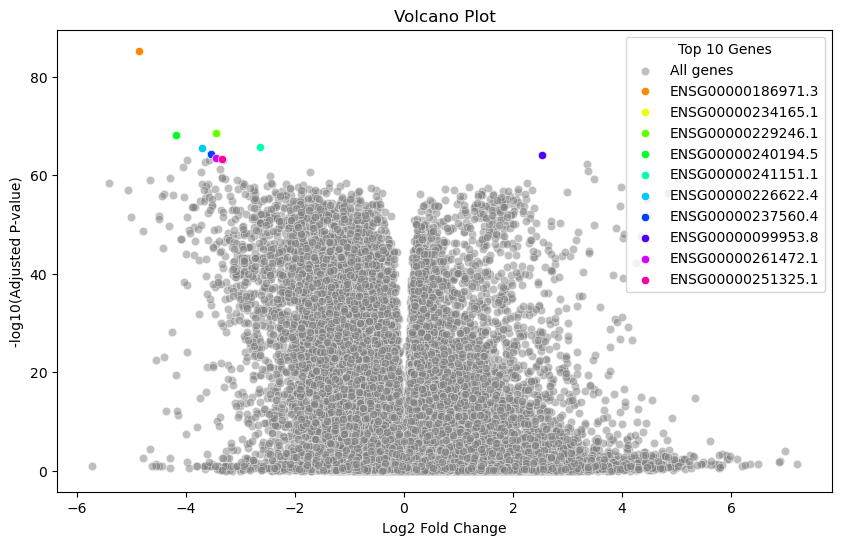

In [19]:
plt.figure(figsize=(10, 6))

# Since we want to give different colors for the top 10 genes
# define a color palette
colors = sns.color_palette('hsv', 10)

# Volcano plot for all genes
sns.scatterplot(data=results_df, x='Log2 Fold Change', y=-np.log10(results_df['Adjusted P-value']),
                color='grey', alpha=0.5, label='All genes')

# Volcano plot for only top 10 genes with colors and legends
x_values = top_10_genes['Log2 Fold Change']
y_values = -np.log10(top_10_genes['Adjusted P-value'])
for i, gene in enumerate(top_10_genes['Gene']):
    sns.scatterplot(x=[x_values[i]], y=[y_values[i]], color=colors[i], label=gene)

# Adding labels and title
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(Adjusted P-value)')
plt.title('Volcano Plot')

# Adding a legend for better readibility
plt.legend(title='Top 10 Genes')

plt.savefig('outputs/volcano_plot_with_legend.pdf')
plt.show()

# Step 4: Gene set enrichment analysis

In [20]:
test_lst = sorted_results_df.head(20)
glist = list(test_lst['Gene']) 

# removing the version number after the dot(.)
queries = {'ensembl_gene_id': [re.sub(r'\.\d+', '', gene) for gene in glist]}
queries

{'ensembl_gene_id': ['ENSG00000186971',
  'ENSG00000234165',
  'ENSG00000229246',
  'ENSG00000240194',
  'ENSG00000241151',
  'ENSG00000226622',
  'ENSG00000237560',
  'ENSG00000099953',
  'ENSG00000261472',
  'ENSG00000251325',
  'ENSG00000269124',
  'ENSG00000257766',
  'ENSG00000254262',
  'ENSG00000167434',
  'ENSG00000123500',
  'ENSG00000267603',
  'ENSG00000224417',
  'ENSG00000230838',
  'ENSG00000168497',
  'ENSG00000255243']}

In [21]:
bm = Biomart()
genemap = bm.query(
    dataset="hsapiens_gene_ensembl",
    attributes=["ensembl_gene_id", "external_gene_name"],
    filters=queries,
)

In [22]:
valid_genes = genemap[genemap["external_gene_name"].notnull()]
valid_genes_list = list(valid_genes["external_gene_name"])

In [23]:
# Gene set enrichment analysis using Enrichr
enrichr_results = gp.enrichr(
    gene_list=valid_genes_list,
    gene_sets=[
        "KEGG_2019_Human",
        "GO_Molecular_Function_2018",
        "GO_Cellular_Component_2018",
        "GO_Biological_Process_2018"
    ],
    organism="human",
    cutoff=0.5,
)

# Debug: Print Enrichr results
# Print Enrichr results DataFrame
print("Enrichr results DataFrame:\n", enrichr_results.res2d)

Enrichr results DataFrame:
                      Gene_set                                            Term  \
0  GO_Biological_Process_2018         plasma membrane tubulation (GO:0097320)   
1  GO_Biological_Process_2018  extracellular matrix organization (GO:0030198)   
2  GO_Biological_Process_2018       plasma membrane organization (GO:0007009)   
3  GO_Biological_Process_2018              bicarbonate transport (GO:0015701)   
4  GO_Biological_Process_2018   extracellular matrix disassembly (GO:0022617)   
5  GO_Biological_Process_2018            organic anion transport (GO:0015711)   
6  GO_Biological_Process_2018        skeletal system development (GO:0001501)   

  Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0    1/12  0.006582          0.023473            0                     0   
1   2/229  0.006707          0.023473            0                     0   
2    1/36  0.019627          0.039070            0                     0   
3    1/41  0.022326

**Plotting the result**

- For KEGG pathways, visualize the enriched pathways.
- For GO-MF terms, visualize the enriched molecular functions.
- For GO-CC terms, visualize the enriched cellular components.
- For GO-BP terms, visualize the enriched biological processes.

<Axes: title={'center': 'Enrichr results'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

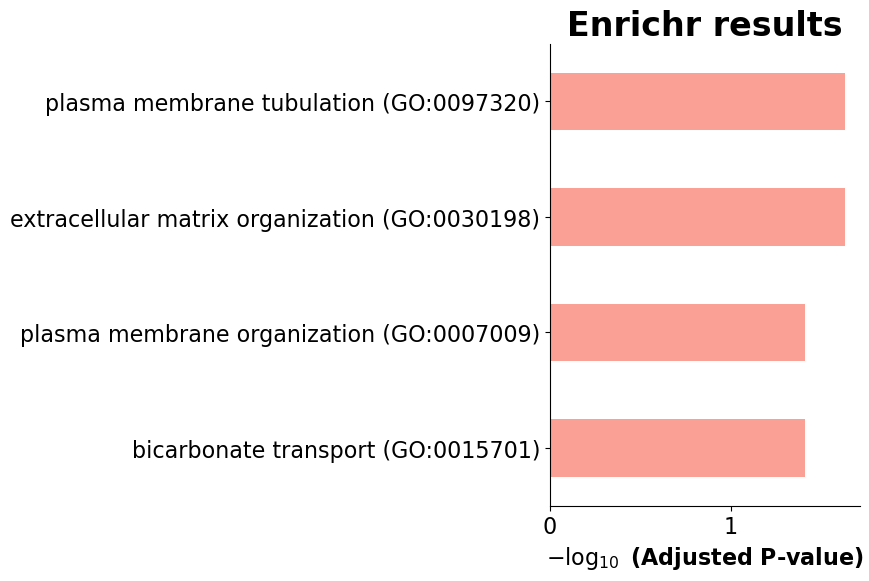

In [24]:
barplot(enrichr_results.res2d, title='Enrichr results', cutoff=0.05)

# Step 5: Repeating for another phenotype variable: Tumor Stage

### Justification for Choosing `tumor_stage.diagnoses` as the Additional Variable

I have chosen `tumor_stage.diagnoses` as the additional variable because it provides insight into the cancer's progression and can reveal key differences in gene expression between early and late-stage cancers. With this we can uncover significant biological insights and clinical implications, contributing to the broader understanding of breast cancer progression.

1. Different tumor stages reflect the progression of cancer and is associated with significant biological changes. By analyzing gene expression across different stages, we can identify key genes and pathways involved in cancer progression and metastasis.

2. These stages are also a critical factor in clinical decision-making, influencing treatment options and prognostic assessments. Understanding how gene expression varies with tumor stage can aid in developing stage-specific therapies and improving patient outcomes.

3. Also, the TCGA dataset provides detailed information on tumor stages, ensuring sufficient sample sizes for robust statistical analyses. This comprehensive data allows for a thorough investigation of stage-specific gene expression patterns.

4. Previous researches, including the referenced paper, highlights the importance of tumor stage in cancer research. Our approach aligns with established methodologies and builds on existing knowledge in the field.


Checking for all the unique entries in this field to ensure different stages of diagnoses.

In [25]:
phenotype_df['tumor_stage.diagnoses'].unique()  

array(['stage iib', 'stage i', 'stage iia', 'stage iv', 'stage iiia',
       'stage x', 'stage ia', 'stage iiic', 'not reported', 'stage ii',
       'stage iiib', 'stage iii', 'stage ib', nan], dtype=object)

Cleaning and categorizing tumor stages

In [26]:
phenotype_variable_stage = "tumor_stage.diagnoses"

phenotype_data = phenotype_df[phenotype_df[phenotype_variable_stage].notnull()]
phenotype_data = phenotype_df[
    ~phenotype_df[phenotype_variable_stage].isin(["stage x", "not reported"])
]

Since we have different sub-stages of cancer we create a dictionary and categorize into early and late stage for our easiness.

In [27]:
# Mapping stages to early and late categories
stage_mapping = {
    "stage i": "early",
    "stage ia": "early",
    "stage ib": "early",
    "stage ii": "early",
    "stage iia": "early",
    "stage iib": "early",
    "stage iii": "late",
    "stage iiia": "late",
    "stage iiib": "late",
    "stage iiic": "late",
    "stage iv": "late",
}

phenotype_data["stage_category"] = phenotype_data[phenotype_variable_stage].map(
    stage_mapping
)

/tmp/ipykernel_7583/258378037.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_data["stage_category"] = phenotype_data[phenotype_variable_stage].map(


Partitioning the phenotype_data into `early_stage_samples` and `late_stage_samples` just as above.

In [28]:
# Partitioning based on stage categories
early_stage_samples = phenotype_data[phenotype_data["stage_category"] == "early"]
late_stage_samples = phenotype_data[phenotype_data["stage_category"] == "late"]

Getting the intersection of indices between `early_stage_samples.index` and `gene_exp_df.index` and filtering out the common indices from gene_exp_df

In [29]:
common_est_samples = set(early_stage_samples.index).intersection(gene_exp_df.index)
common_est_samples_list = list(common_est_samples)

common_est_samples_df = gene_exp_df.loc[common_est_samples_list]
common_est_samples_df = common_est_samples_df.apply(pd.to_numeric, errors="coerce")
common_est_samples_df = common_est_samples_df.dropna()
common_est_samples_df.head()

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000238244.3,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-GM-A3XL-01A,0.000000,0.000000,1.954832,0.0,2.331209,3.947551,0.0,0.022546,7.075187,0.000000,...,0.0,0.007195,0.0,0.236459,0.000000,3.931436,0.493768,0.0,0.632312,0.00000
TCGA-E2-A15F-01A,0.000000,0.011635,2.554036,0.0,2.027531,3.369281,0.0,0.021811,6.393080,0.515941,...,0.0,0.000000,0.0,0.248426,0.068508,4.709851,0.156425,0.0,0.417914,0.00000
TCGA-AR-A0TR-01A,0.028215,0.000000,1.535255,0.0,1.328942,3.897586,0.0,0.008091,7.568541,0.149421,...,0.0,0.069141,0.0,0.131446,0.000000,4.004238,0.292539,0.0,0.246190,0.01512
TCGA-E2-A10C-01A,0.000000,0.000000,3.385876,0.0,2.241411,3.445868,0.0,0.277172,6.984037,0.220952,...,0.0,0.057432,0.0,0.311646,0.201343,4.114450,0.262861,0.0,0.485206,0.00000
TCGA-A8-A0AD-01A,0.042237,0.000000,1.515587,0.0,2.078508,2.900330,0.0,0.004063,6.797060,0.000000,...,0.0,0.000000,0.0,0.067406,0.000000,3.661142,0.246792,0.0,0.284159,0.00000


In [30]:
common_lst_samples = set(late_stage_samples.index).intersection(gene_exp_df.index)
common_lst_samples_list = list(common_lst_samples)
common_lst_samples_df = gene_exp_df.loc[common_lst_samples_list]

common_lst_samples_df = common_lst_samples_df.apply(pd.to_numeric, errors="coerce")
common_lst_samples_df = common_lst_samples_df.dropna()
common_lst_samples_df.head()

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000238244.3,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SJ-01A,0.000000,0.000000,1.957792,0.0,1.300873,3.570082,0.0,0.069682,7.233006,0.000000,...,0.0,0.038119,0.0,0.000000,0.0,3.989149,0.078343,0.0,0.261174,0.0
TCGA-AR-A24O-01A,0.151617,0.004430,1.649990,0.0,2.154164,3.153092,0.0,0.010584,7.425159,0.113217,...,0.0,0.049710,0.0,0.099448,0.0,3.345814,0.263113,0.0,0.616928,0.0
TCGA-AN-A0FJ-01A,0.000000,0.000000,1.456777,0.0,2.498500,3.623509,0.0,0.013968,7.319783,0.154799,...,0.0,0.000000,0.0,0.178894,0.0,3.542557,0.132970,0.0,0.342829,0.0
TCGA-A2-A0SV-01A,0.000000,0.000000,1.868292,0.0,2.276370,4.251579,0.0,0.105429,7.215973,0.114558,...,0.0,0.000000,0.0,0.081059,0.0,4.138118,0.117076,0.0,0.793078,0.0
TCGA-E9-A1RI-01A,0.029946,0.004192,2.120184,0.0,2.517058,3.055131,0.0,0.002869,7.295379,0.254772,...,0.0,0.000000,0.0,0.455698,0.0,3.804837,0.146675,0.0,0.463350,0.0


## Performing MannWhiteneyU test

In [31]:
_p_values = []
_adjusted_p_values = []
_log2_fold_changes = []
_epsilon = 1e-8

# iterating over each genes
for gene in common_est_samples_df.columns:
    # Mann-Whitney U test
    stat, p_value = mannwhitneyu(
        common_est_samples_df[gene], common_lst_samples_df[gene], alternative="two-sided"
    )

    # p-value for each gene
    _p_values.append(p_value)

    # log2 fold change (assuming mean expression for simplicity)
    mean_expression_early_stage = common_est_samples_df[gene].mean(axis=0)
    mean_expression_late_stage = common_lst_samples_df[gene].mean(axis=0)
    log2_fold_change = np.log2(
        mean_expression_early_stage / (mean_expression_late_stage)
    )
    _log2_fold_changes.append(log2_fold_change)

    # Append nan for adjusted p-value for now (will calculate later)
    _adjusted_p_values.append(np.nan)

/tmp/ipykernel_7583/3696687009.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  mean_expression_early_stage / (mean_expression_late_stage)
/tmp/ipykernel_7583/3696687009.py:20: RuntimeWarning: invalid value encountered in scalar divide
  mean_expression_early_stage / (mean_expression_late_stage)
/tmp/ipykernel_7583/3696687009.py:19: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(


In [32]:
_, _adjusted_p_values, _, _ = smm.multipletests(_p_values, alpha=0.05, method="fdr_bh")

In [42]:
print(_adjusted_p_values)

[0.96256671 0.4665349  1.         ... 0.98775805 0.86757912 0.89528868]


In [33]:
_results_df = pd.DataFrame(
    {
        "Gene": common_est_samples_df.columns,
        "P-value": _p_values,
        "Adjusted P-value": _adjusted_p_values,
        "Log2 Fold Change": _log2_fold_changes,
    }
)
_results_df.to_csv("differential_expression_results_stage.csv", index=False)

## Volcano plot

In [34]:
_sorted_results_df = _results_df.sort_values(by="Adjusted P-value")

_top_10_genes = _sorted_results_df.head(10)
_top_10_genes.reset_index(drop=True, inplace=True)

* The volcano plot shows the top 10 genes with the smallest adjusted p-values and their log2 fold changes.
* The x-axis represents the log2 fold change, and the y-axis represents the negative log10 of the adjusted p-value. 
* The top 10 genes are highlighted with different colors and labeled in the legend for easy identification.
* This shows the differential expression of genes between early and late-stage breast cancer samples.

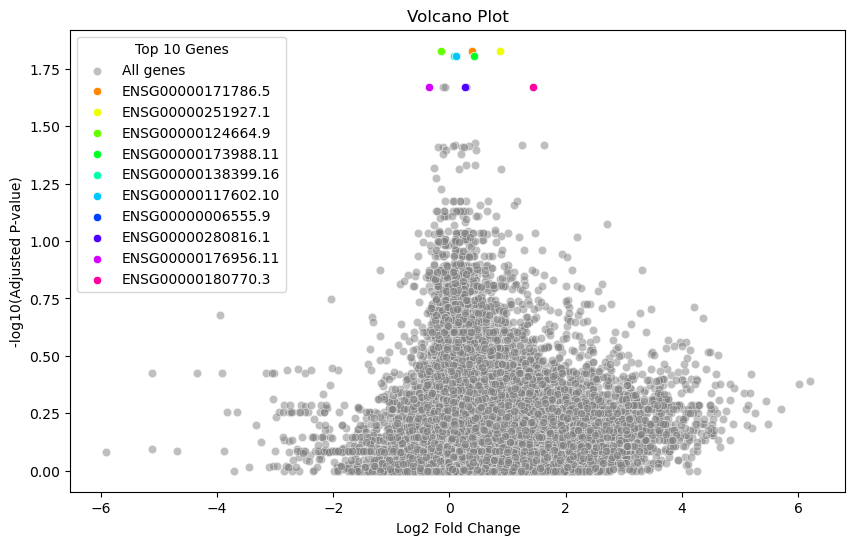

In [35]:
plt.figure(figsize=(10, 6))

# Since we want to give different colors for the top 10 genes
# define a color palette
_colors = sns.color_palette("hsv", 10)

# Volcano plot for all genes
sns.scatterplot(
    data=_results_df,
    x="Log2 Fold Change",
    y=-np.log10(_results_df["Adjusted P-value"]),
    color="grey",
    alpha=0.5,
    label="All genes",
)

# Volcano plot for only top 10 genes with colors and legends
_x_values = _top_10_genes["Log2 Fold Change"]
_y_values = -np.log10(_top_10_genes["Adjusted P-value"])
for i, gene in enumerate(_top_10_genes["Gene"]):
    sns.scatterplot(x=[_x_values[i]], y=[_y_values[i]], color=_colors[i], label=gene)
    
# Adding labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-log10(Adjusted P-value)")
plt.title("Volcano Plot")

# Adding a legend for better readibility
plt.legend(title="Top 10 Genes")

plt.savefig("outputs/volcano_plot_stage.pdf")
plt.show()


### Gene set enrichment analysis of different cancer stages

In [36]:
_test_lst = _sorted_results_df.head(20)
glist = list(_test_lst["Gene"])

# removing the version number after the dot(.)
queries = {"ensembl_gene_id": [re.sub(r"\.\d+", "", gene) for gene in glist]}
queries

{'ensembl_gene_id': ['ENSG00000171786',
  'ENSG00000251927',
  'ENSG00000124664',
  'ENSG00000173988',
  'ENSG00000138399',
  'ENSG00000117602',
  'ENSG00000006555',
  'ENSG00000280816',
  'ENSG00000176956',
  'ENSG00000180770',
  'ENSG00000273982',
  'ENSG00000106211',
  'ENSG00000171790',
  'ENSG00000253301',
  'ENSG00000197961',
  'ENSG00000250609',
  'ENSG00000234129',
  'ENSG00000115368',
  'ENSG00000058085',
  'ENSG00000159423']}

Using the Biomart API to get the gene names for the top 20 genes with smallest adjusted p-values in stage analysis 

In [37]:
bm = Biomart()
genemap = bm.query(
    dataset="hsapiens_gene_ensembl",
    attributes=["ensembl_gene_id", "external_gene_name"],
    filters=queries,
)

_valid_genes = genemap[genemap["external_gene_name"].notnull()]
_valid_genes_list = list(_valid_genes["external_gene_name"])

In [54]:
_enrichr_results = gp.enrichr(
    gene_list=_valid_genes_list,
    gene_sets=[
        "KEGG_2019_Human",
        "GO_Molecular_Function_2018",
        "GO_Cellular_Component_2018",
        "GO_Biological_Process_2018",
        "Reactome_2013",
        "Reactome_2015",
        "Reactome_2016",
    ],
    organism="human",
    cutoff=0.5,
)

# Print Enrichr results DataFrame
print("Enrichr results DataFrame:\n", _enrichr_results.res2d)

Enrichr results DataFrame:
          Gene_set                                               Term Overlap  \
0   Reactome_2016  Anchoring fibril formation Homo sapiens R-HSA-...     1/7   
1   Reactome_2016  Type I hemidesmosome assembly Homo sapiens R-H...     1/9   
2   Reactome_2016    Laminin interactions Homo sapiens R-HSA-3000157    1/23   
3   Reactome_2016  Histidine, lysine, phenylalanine, tyrosine, pr...    1/41   
4   Reactome_2016  Non-integrin membrane-ECM interactions Homo sa...    1/42   
5   Reactome_2016  Assembly of collagen fibrils and other multime...    1/54   
6   Reactome_2016  AUF1 (hnRNP D0) binds and destabilizes mRNA Ho...    1/54   
7   Reactome_2016  rRNA modification in the nucleus Homo sapiens ...    1/58   
8   Reactome_2016      Collagen formation Homo sapiens R-HSA-1474290    1/85   
9   Reactome_2016  Cell junction organization Homo sapiens R-HSA-...    1/86   
10  Reactome_2016  Regulation of mRNA stability by proteins that ...    1/86   
11  Reactome

#### Plotting the results using barplot function from gseapy package 

<Axes: title={'center': 'Enrichr results'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

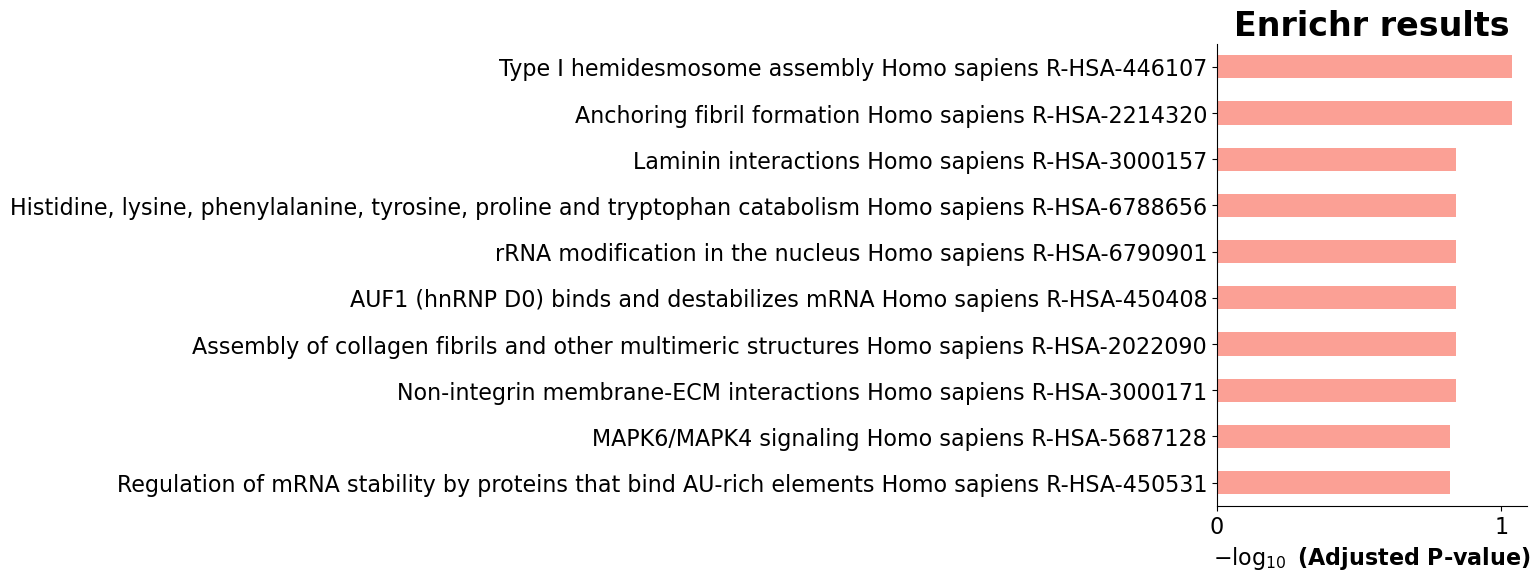

In [55]:
barplot(_enrichr_results.res2d, title="Enrichr results", cutoff=0.5)